In [1]:

import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, DepthwiseConv2D, Activation, Add
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import shuffle
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor, Compose, Resize

In [2]:
train_path=os.getenv('HOME') + '/aiffel/jellyfish/new/Train'
test_path=os.getenv('HOME') + '/aiffel/jellyfish/new/test'
valid_path=os.getenv('HOME') + '/aiffel/jellyfish/new/valid'

trainset=ImageFolder(train_path,transform=Compose([Resize((224,224)),ToTensor()]))
testset=ImageFolder(test_path,transform=Compose([Resize((224,224)),ToTensor()]))
validset=ImageFolder(valid_path,transform=Compose([Resize((224,224)),ToTensor()]))

In [3]:
trainset
# testset
# validset

Dataset ImageFolder
    Number of datapoints: 1813
    Root location: /aiffel/aiffel/jellyfish/new/Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

In [4]:
from torch.utils.data import DataLoader
train_loader=DataLoader(trainset,batch_size=4,shuffle=True)
test_loader=DataLoader(testset,batch_size=4)
valid_loader=DataLoader(validset,batch_size=4)

In [5]:
pip install torchvision==0.12.0

Note: you may need to restart the kernel to use updated packages.


In [6]:
from torchvision.models import vit_b_16
from torch import nn
model=vit_b_16(pretrained=True)
model.heads.head=nn.Linear(768,6)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /aiffel/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [7]:
from torch.optim import Adam
from torch import nn
import torch
clf=model.to('cuda')
opt=Adam(clf.parameters(), lr=1e-6)
lossfn=nn.CrossEntropyLoss()

In [8]:
for e in range(5):
    clf.train()
    correct=0
    items=0
    for X,y in train_loader:
        X=X.to('cuda')
        y=y.to('cuda')
        yhat=clf(X)
        pred=torch.argmax(yhat,1)
        loss=lossfn(yhat,y)

        opt.zero_grad()
        loss.backward()
        opt.step()
        correct+=(pred==y).sum()
        items+=y.size(0)
    print(f"Epoch {e} Train accuracy {correct*100/items}")
    clf.eval()
    with torch.no_grad():
        correct=0
        items=0
        for X,y in valid_loader:
            X=X.to('cuda')
            y=y.to('cuda')
            yhat=clf(X)
            pred=torch.argmax(yhat,1)
            loss=lossfn(yhat,y)

            correct+=(pred==y).sum()
            items+=y.size(0)
        print(f"Valid accuracy {correct*100/items}")

Epoch 0 Train accuracy 44.07059860229492
Valid accuracy 70.4917984008789
Epoch 1 Train accuracy 81.13623809814453
Valid accuracy 87.43169403076172
Epoch 2 Train accuracy 92.55377197265625
Valid accuracy 89.61748504638672
Epoch 3 Train accuracy 95.80805206298828
Valid accuracy 89.07103729248047
Epoch 4 Train accuracy 97.84886169433594
Valid accuracy 89.07103729248047


In [9]:
clf.eval()
y_label=[]
y_pred=[]
with torch.no_grad():
    correct=0
    items=0
    for X,y in test_loader:
        X=X.to('cuda')
        y=y.to('cuda')
        yhat=clf(X)
        pred=torch.argmax(yhat,1)
        loss=lossfn(yhat,y)

        correct+=(pred==y).sum()
        items+=y.size(0)
        y_label.extend(y.to('cpu'))
        y_pred.extend(pred.to('cpu'))
    print(f"Test accuracy {correct*100/items}")

Test accuracy 92.6229476928711


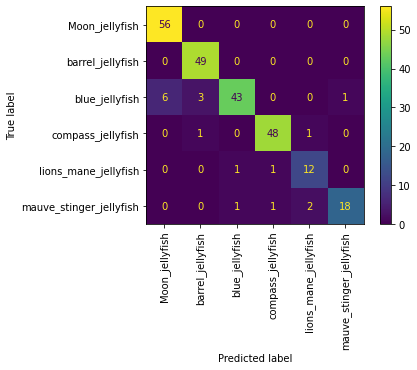

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay as cmd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

cm=confusion_matrix(y_label,y_pred)
disp=cmd(cm,display_labels=trainset.classes)
disp.plot()
plt.xticks(rotation=90)
plt.show()

In [11]:
from sklearn.metrics import classification_report as cfr
print(cfr(y_label,y_pred))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95        56
           1       0.92      1.00      0.96        49
           2       0.96      0.81      0.88        53
           3       0.96      0.96      0.96        50
           4       0.80      0.86      0.83        14
           5       0.95      0.82      0.88        22

    accuracy                           0.93       244
   macro avg       0.92      0.91      0.91       244
weighted avg       0.93      0.93      0.92       244



In [12]:
from sklearn.metrics import f1_score
print(f1_score(y_label,y_pred,average='micro'))

0.9262295081967213
